Technical Analysis libraries:   
* pip install TA-Lib         ---- 150 + indicators, supports work with pandasd. TA-Lib is the golden standard, but it is not the easiest one to understand and dive deep into.
* pip install --upgrade ta   ---- 42 indicators, supports work with pandas. ( Can run all 42 indicators in one line of code).  
* pip install pandas_ta      ---- 130+ indicators, supports work with pandas.   

*** Read more here : https://medium.com/geekculture/top-4-python-libraries-for-technical-analysis-db4f1ea87e09

Portfolio Assessment libraries:
* pip install pyfolio -- Portfolio analysis (seems like it is not supported anymore)

In [1]:
import requests as r
import pandas as pd 
import numpy as np
import json as j
import time
from datetime import timedelta
from scipy.stats import geom

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf
import seaborn as sns

from Scraping import Navigation as Nav
import os
import shutil


MARKETS = ['NASDAQ', 'NYSE']
DOWNLOADS_DIR = r'C:\Users\Vasyl\Downloads'
LAST_DAY_DATA_DIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\Stock Analysis\P1-Indicators-Chart-Analysis\Data\Last Day'
STOCK_LIST = ['MSFT','TSLA','BABA','VZ','AAPL', 'NEM'] # 

import yaml
def load_yaml_file(filename):
    with open(filename, "r") as file:
        data = yaml.safe_load(file)
    return data

KEY = load_yaml_file(r"C:\Users\Vasyl\Google Drive\Vantage API Secret key\AlphaVantageAPIPremiumKey.yaml")['ALPHA_VANTAGE_PREMIUM_KEY']
CALLS_PER_MINUTE = 75
SLEEP_TIME = 60/CALLS_PER_MINUTE + (60/CALLS_PER_MINUTE)*0.1 # 75 requests per minute with 10% buffer

### Getting data from aplha vantage API and storing it in csv files

Daily data:

In [2]:
def get_daily_adjusted_data(ticker,key,full_or_compact='full'):
    url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={key}&outputsize={full_or_compact}'
    response = r.get(url_json)
    j_response = response.json()
    formated_response = j.dumps(j_response, indent=4)
    return formated_response

In [3]:
def get_daily_adjusted_data_for_list(ticker_list,key,full_or_compact):
    for ticker in ticker_list:
        if os.path.exists(f'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days\{ticker}-daily-100days.csv'):
            pass
        elif os.path.exists(f'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days\{ticker}.json'):
            pass
        else:
            data = get_daily_adjusted_data(ticker,key,full_or_compact)
            data = j.loads(data)
            try:
                df = pd.DataFrame(data['Time Series (Daily)']).T
                df.index.name = 'Date'
                df.to_csv(f'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days\{ticker}-daily-100days.csv')
                time.sleep(SLEEP_TIME) # API limit is 75 calls per minute
                print(f'{ticker_list.index(ticker)/len(ticker_list)*100:.2f}%')
            except KeyError:
                print(f'No data for {ticker}. Saving Json file')
                print(data)
                with open(f'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days\{ticker}.json', 'w') as f:
                    j.dump(data, f)
                continue
            

Hourly data: (for the last 2 years)

In [4]:
def get_intraday_extended_data(ticker,key,interval='60min',slice='year1month1'):
    if slice == '2yearData':
        months = ['1','2','3','4','5','6','7','8','9','10','11','12']
        years = ['1','2']
        with open(f'..\P1-Indicators-Chart-Analysis\Data\Hourly\{ticker}-2years-hourly.csv', 'w') as f:
            for year in years:
                for month in months:
                    slice = f'year{year}month{month}'
                    url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&slice={slice}&apikey={key}'
                    response = r.get(url_json)
                    f.write(response.text)
                    time.sleep(SLEEP_TIME) # API limit is 75 calls per minute
    else:
        url_json = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={ticker}&interval={interval}&slice={slice}&apikey={key}'
        response = r.get(url_json)
        with open(f'..\P1-Indicators-Chart-Analysis\Data\Hourly\{ticker}-30days-hourly.csv', 'w') as f:
            f.write(response.text)

In [5]:
# for ticker in STOCK_LIST:
#     get_intraday_extended_data(ticker,KEY,slice='2yearData')

### Data Visualization and Chart Analysis

In [6]:
# load data from csvs
aapl_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\AAPL-daily.csv', index_col=0,parse_dates=True)
baba_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\BABA-daily.csv', index_col=0,parse_dates=True)
msft_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\MSFT-daily.csv', index_col=0,parse_dates=True)
nem_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\NEM-daily.csv', index_col=0,parse_dates=True)
tsla_d_source = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\TSLA-daily.csv', index_col=0,parse_dates=True)
vz_d_source= pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Daily\VZ-daily.csv', index_col=0,parse_dates=True)

aapl_d_source.index.rename('Date', inplace=True)
baba_d_source.index.rename('Date', inplace=True)
msft_d_source.index.rename('Date', inplace=True)
nem_d_source.index.rename('Date', inplace=True)
tsla_d_source.index.rename('Date', inplace=True)
vz_d_source.index.rename('Date', inplace=True)

In [7]:
aapl_d_source.head(2)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2023-03-10,150.210,150.940,147.6096,148.50,148.50,68572400,0.0,1.0
2023-03-09,153.559,154.535,150.2250,150.59,150.59,53833582,0.0,1.0


Check if data is actually adjusted for splits and dividends as it should be per the API documentation:

In [8]:
aapl_d_source['8. split coefficient'].value_counts()

1.000000    5873
2.000000       2
4.000000       1
7.000007       1
Name: 8. split coefficient, dtype: int64

In [9]:
splits = aapl_d_source[~aapl_d_source['8. split coefficient'].isin([1])].copy(deep=True)
splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
splits

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2020-08-31,127.58,131.00,126.00,129.04,126.935683,223505733,0.0,4
2014-06-09,92.70,93.88,91.75,93.70,20.831391,75414997,0.0,7
2005-02-28,44.68,45.14,43.96,44.86,1.361730,11635900,0.0,2
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2


Quick check online confirms that these are the dates of the splits for AAPL stock.  
Let's see if the next day's open price is adjusted for the split.

In [10]:
aapl_d_source.loc['2000-06-19':'2000-06-26':-1]
# aapl_d_source.loc['2005-02-24':'2005-03-01':-1]
# aapl_d_source.loc['2014-06-06':'2014-06-11':-1]
# aapl_d_source.loc['2020-08-27':'2020-09-02':-1]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2000-06-19,90.56,97.87,89.81,96.62,0.733228,3517900,0.0,1.0
2000-06-20,98.50,103.94,98.37,101.25,0.768364,4476700,0.0,1.0
2000-06-21,50.50,56.94,50.31,55.63,0.844327,4375000,0.0,2.0
2000-06-22,55.75,57.63,53.56,53.75,0.815794,8352000,0.0,1.0
2000-06-23,53.78,54.63,50.81,51.69,0.784528,3660100,0.0,1.0
2000-06-26,52.50,54.75,52.13,54.13,0.821561,3309900,0.0,1.0


As we can see the column "5. adjusted close" indicates the adjusted close price for the split. Great.   
However to use some of the indicators we need to use the high, low, open and close prices.

Adjusting for the splits:

* Saving function to reuse later.

In [11]:
def adjust_price_for_splits(df):
    splits = df[~df['8. split coefficient'].isin([1])].copy(deep=True)
    splits['8. split coefficient'] = splits['8. split coefficient'].astype('int')
    new_df = df.copy(deep=True)
    for split in splits.index:
        new_df.loc[split-timedelta(days=1):,'1. open'] = new_df.loc[split:,'1. open'] / splits.loc[split,'8. split coefficient']
        new_df.loc[split-timedelta(days=1):,'2. high'] = new_df.loc[split:,'2. high'] / splits.loc[split,'8. split coefficient']
        new_df.loc[split-timedelta(days=1):,'3. low'] = new_df.loc[split:,'3. low'] / splits.loc[split,'8. split coefficient']
        new_df.loc[split-timedelta(days=1):,'4. close'] = new_df.loc[split:,'4. close'] / splits.loc[split,'8. split coefficient']  
    new_df = new_df.rename(columns={'1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close', '6. volume':'Volume'})
    new_df = new_df[::-1]
    return new_df, splits

In [12]:
aapl_d, aapl_splits = adjust_price_for_splits(aapl_d_source)
baba_d, baba_splits = adjust_price_for_splits(baba_d_source)
msft_d, msft_splits = adjust_price_for_splits(msft_d_source)
nem_d, nem_splits = adjust_price_for_splits(nem_d_source)
tsla_d, tsla_splits = adjust_price_for_splits(tsla_d_source)
vz_d, vz_splits = adjust_price_for_splits(vz_d_source)

aapl_d.name = 'AAPL'
baba_d.name = 'BABA'
msft_d.name = 'MSFT'
nem_d.name = 'NEM'
tsla_d.name = 'TSLA'
vz_d.name = 'VZ'
# For Easy access to the data and manipulation
growth = [aapl_d, baba_d, msft_d, tsla_d]
value = [nem_d, vz_d]
all_stocks = [aapl_d, baba_d, msft_d, nem_d, tsla_d, vz_d]

In [13]:
# aapl_d.loc['2000-06-19':'2000-06-26':1]
# aapl_d.loc['2005-02-24':'2005-03-01':1]
aapl_d.loc['2014-06-06':'2014-06-11':1]
# aapl_d_.loc['2020-08-27':'2020-09-02':1]

,Open,High,Low,Close,5. adjusted close,Volume,7. dividend amount,8. split coefficient
Date,,,,,,,,
2014-06-06,23.210714,23.259286,23.016786,23.056071,20.503289,12497800,0.0,1.000000
2014-06-09,23.175000,23.470000,22.937500,23.425000,20.831391,75414997,0.0,7.000007
2014-06-10,23.682500,23.762500,23.392500,23.562500,20.953667,62777000,0.0,1.000000
2014-06-11,23.532500,23.690000,23.367500,23.465000,20.866962,45681000,0.0,1.000000


#### Plotting stock price and volume for the last 2 years

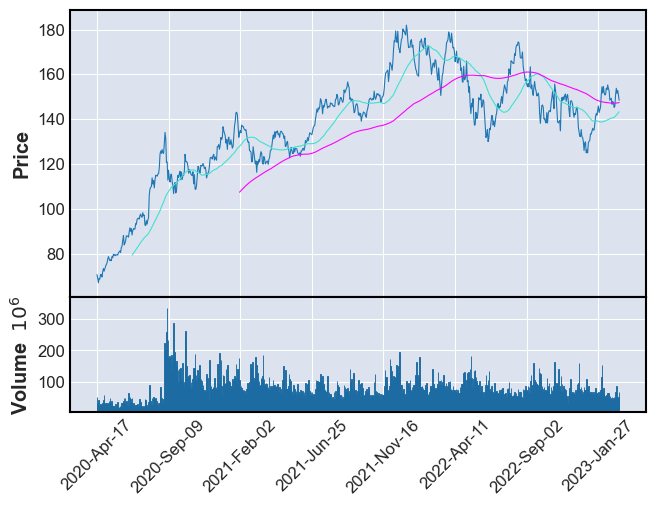

In [14]:
mpf.plot(aapl_d[-730::], type='line',  volume=True,  mav=(50, 200)) # quick plot

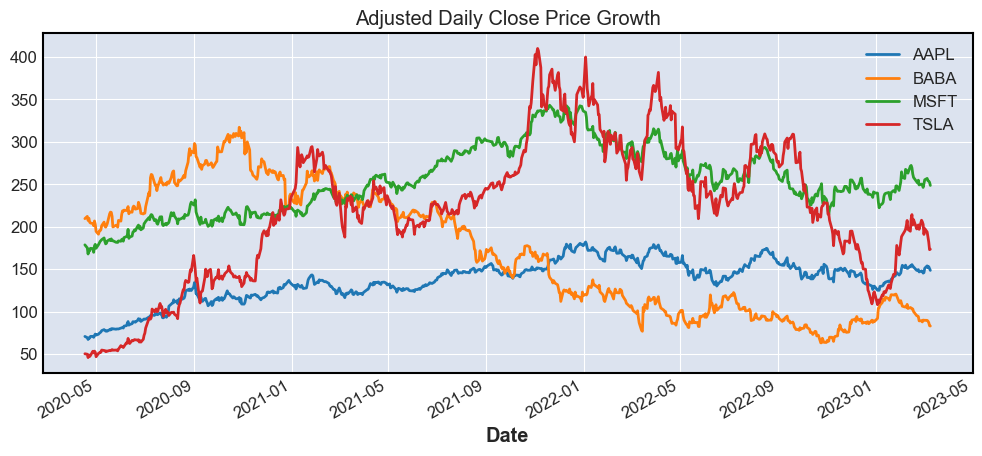

In [15]:
aapl_d['Close'][-730:].plot(figsize=(12,5),label='AAPL', title='Adjusted Daily Close Price Growth')
baba_d['Close'][-730:].plot(label='BABA')
msft_d['Close'][-730:].plot(label='MSFT')
tsla_d['Close'][-730:].plot(label='TSLA')
plt.legend()

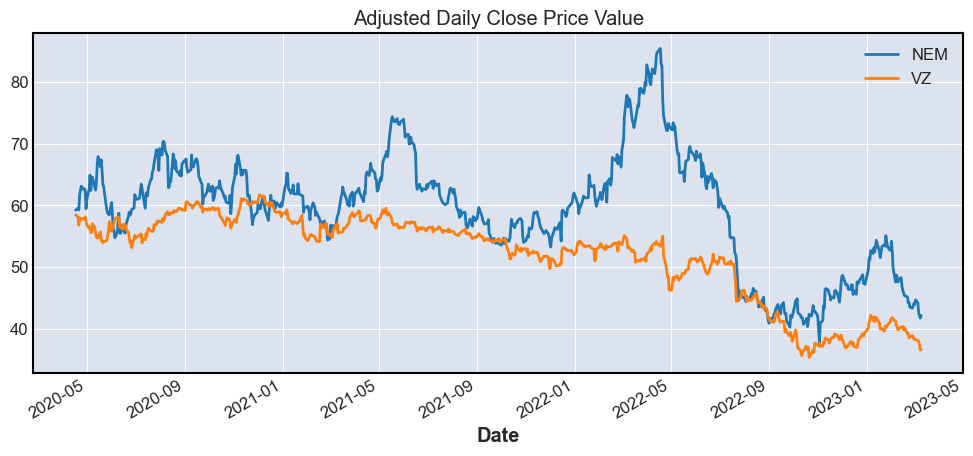

In [16]:
nem_d['Close'][-730:].plot(label='NEM',figsize=(12,5), title='Adjusted Daily Close Price Value')
vz_d['Close'][-730:].plot(label='VZ')
plt.legend()

In [17]:
for stock in all_stocks:
    stock['MA30'] = stock['Close'].rolling(30).mean()
    stock['MA120'] = stock['Close'].rolling(120).mean()

<Axes: title={'center': 'APPL MA30 and MA120'}, xlabel='Date'>

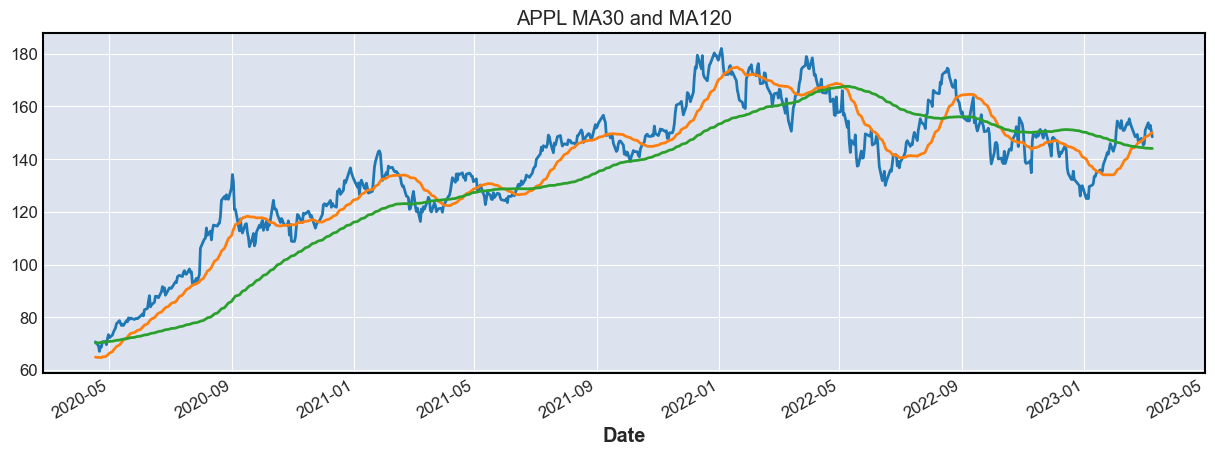

In [18]:
aapl_d['Close'][-730:].plot(figsize=(15,5),label='AAPL', title='APPL MA30 and MA120')
aapl_d['MA30'][-730:].plot(label='MA30')
aapl_d['MA120'][-730:].plot(label='MA120')

#### Conditional probability.
Determining probability of the stock moving up or down based on previous day movement (+2%, +3%, +4%, +5%, +6%) and (-2%, -3%,-4%, -5%, -6%) for different time frames


In [19]:
for stock in all_stocks:
    stock['Daily Return'] = stock['Close'].pct_change() # Calculate the daily returns for each stock into a new column called 'Daily Return'
    conditions = [stock['Daily Return'] < -0.05, 
                stock['Daily Return'].between(-0.05, -0.04, inclusive='left'), 
                stock['Daily Return'].between(-0.04, -0.03, inclusive='left'), 
                stock['Daily Return'].between(-0.03, -0.02, inclusive='left'), 
                stock['Daily Return'].between(-0.02, -0.01, inclusive='left'), 
                stock['Daily Return'].between(-0.01, 0, inclusive='left'), 
                stock['Daily Return'].between(0, 0.01, inclusive='left'), 
                stock['Daily Return'].between(0.01, 0.02, inclusive='left'), 
                stock['Daily Return'].between(0.02, 0.03, inclusive='left'), 
                stock['Daily Return'].between(0.03, 0.04, inclusive='left'), 
                stock['Daily Return'].between(0.04, 0.05, inclusive='left'), 
                stock['Daily Return'] >= 0.05]
    values = [-5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4, 5]
    stock['return bucket'] = np.select(conditions, values)
    stock = stock[~stock['Daily Return'].isnull()] 
for stock in all_stocks:
    # create column called 'UP or DOWN' to indicate whether the stock price increased or decreased and populate it based on the 'return bucket' column
    conditions = [stock['return bucket'].isin([ -1, -2, -3, -4, -5]),
                  stock['return bucket'].isin([0, 1, 2, 3, 4, 5])]
    values = [-1, 1]
    stock['UP or DOWN'] = np.select(conditions, values)

In [20]:
# calculate probability of each return bucket
aapl_d['return bucket'].value_counts(normalize=True)

 0    0.439850
 1    0.147524
-1    0.116386
 2    0.068913
-2    0.067381
 3    0.038625
-3    0.030968
 5    0.027565
-5    0.022290
 4    0.021099
-4    0.019398
Name: return bucket, dtype: float64

* Here is a function which can give us probabilities for stock to go up or down based on previous day percentage change.

In [21]:
def calc_proba_price_change_based(stock_df, percentChange, days, print_proba=False):
    '''Calculates probabilities of a stock to go up or down next day, based on percent change in price of present day.
    '''
    df = stock_df.copy(deep=True)[-days:]
    # shift return bucket column up by one row to match the previous day's return bucket
    df['previous_day_return_bucket'] = df['return bucket'].rolling(2).apply(lambda x: x[0])
    # calculate probability of up or down given previous day's return bucket
    proba_df = df[['previous_day_return_bucket','UP or DOWN']].value_counts(normalize=True).to_frame().rename(columns={0:'Probability'}).pivot_table(columns='previous_day_return_bucket', index='UP or DOWN', values='Probability')
    percentChange = float(percentChange)
    final_series = proba_df[percentChange].rename(index={-1.0:'Negative', 1.0:'Positive'})
    for r in final_series.index:
        if print_proba:
            final_series = final_series / final_series.sum() * 100
            print(f'Probability of {r} is {round(final_series[r],2)}%')
    return proba_df

In [22]:
calc_proba_price_change_based(tsla_d, percentChange=1, days=365, print_proba=True)

Probability of Negative is 37.5%
Probability of Positive is 62.5%


previous_day_return_bucket,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0
UP or DOWN,,,,,,,,,,,
-1,0.030220,0.016484,0.019231,0.035714,0.032967,0.098901,0.041209,0.021978,0.021978,0.008242,0.024725
1,0.093407,0.035714,0.024725,0.030220,0.035714,0.159341,0.068681,0.035714,0.057692,0.032967,0.074176


* Calculating colinearity between the stocks

In [23]:
# Make a comparison table for all 5 stocks I have entered above. This should give collinearity.
def compare_stocks(all_stocks, days):
    colinearity_df = pd.DataFrame()
    for stock in all_stocks:
        df = calc_proba_price_change_based(stock, percentChange=0, days=days, print_proba=False)
        df = df.iloc[1].to_frame().T
        df.index = [stock.name] * len(df)
        colinearity_df = pd.concat([colinearity_df, df], axis=0)
    sns.heatmap(colinearity_df.T.corr(), annot=True, cmap='coolwarm')
    return colinearity_df

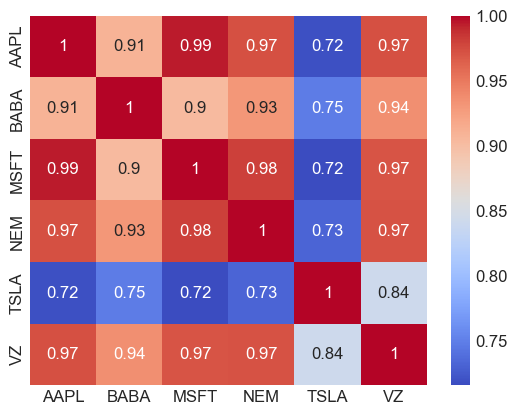

In [24]:
col_df = compare_stocks(all_stocks, days=365*1)

* Function to calculate the probalility of trend going UP or DOWN based on the previous movement over last few days.   
We can use Geometric distribution and PMF - Probability Mass Function from SciPy module to calculate the probability of the stock going up or down based on the previous movement.

In [25]:
aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1] # probability of AAPL going up on any day

0.7435766547558278

In [26]:
up_chance = aapl_d['UP or DOWN'].value_counts(normalize=True).loc[1]
geom.pmf(5, up_chance)

0.0032148150490222075

In [27]:
def proba_up_down(stock_df, cont_days, period_days, direction):
    '''Calculates probability of a stock to go on specified direction for a given number of days in a row.
    '''
    if direction == 'up':
        direction_int = 1
    if direction == 'down':
        direction_int = -1
    df = stock_df.copy(deep=True)[-period_days:]
    proba = geom.pmf(cont_days, df['UP or DOWN'].value_counts(normalize=True).loc[direction_int])
    print(f'Probability of {stock_df.name} going "{direction.upper()}" for {cont_days} days in a row is {round(proba*100,3)}%. Based on {period_days} days of data.')

In [28]:
proba_up_down(aapl_d, cont_days=15, period_days=365*10, direction='down')

Probability of AAPL going "DOWN" for 15 days in a row is 0.746%. Based on 3650 days of data.


* Screen through all Nasdaq and NYSE stocks and find the top 10 trending stocks (rank based on percentage change for the day). 	Only for 1 last day.

Scraping data from NASQAD website.

In [29]:
def get_last_day_data(MARKETS):
    for file in os.listdir(DOWNLOADS_DIR):
            if file.startswith('nasdaq_screener_'):
                os.remove(os.path.join(DOWNLOADS_DIR, file))
    for file in os.listdir(LAST_DAY_DATA_DIR):
            if file.endswith('last_day.csv'):
                os.remove(os.path.join(LAST_DAY_DATA_DIR, file))

    driver = Nav.create_driver(chromeOptions={})
    for market in MARKETS:
        url = rf'https://www.nasdaq.com/market-activity/stocks/screener?exchange={market}&render=download'
        driver.get(url)
        Nav.click_element(driver,path='//body/div[2]/div/main/div[2]/article/div[3]/div[1]/div/div/div[3]/div[2]/div[2]/div/button',wait_time=5)
        time.sleep(6)

        for file in os.listdir(DOWNLOADS_DIR):
            if file.startswith('nasdaq_screener_'):
                newName =  f'{market.lower()}_last_day.csv'
                shutil.move(os.path.join(DOWNLOADS_DIR,file), rf'{LAST_DAY_DATA_DIR}\{newName}')
                print('Downloaded', newName)

    driver.quit()

get_last_day_data(MARKETS)

Downloaded nasdaq_last_day.csv
Downloaded nyse_last_day.csv


#### Top 10 trending stocks for the last day.

In [30]:
nasdaq_df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Last Day\nasdaq_last_day.csv')
nyse_df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\Last Day\nyse_last_day.csv')

In [31]:
total_markets_fd = pd.concat([nasdaq_df, nyse_df], axis=0)
total_markets_fd.shape 

(7538, 11)

In [32]:
#cleaning data before sorting
print(total_markets_fd.loc[:,'% Change'].isna().sum())
total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].fillna('0.00%')
print(total_markets_fd.loc[:,'% Change'].isna().sum())
total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].apply(lambda x: float(x.strip('%')))

1
0


C:\Users\Vasyl\AppData\Local\Temp\ipykernel_13108\1650416781.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  total_markets_fd.loc[:,'% Change'] = total_markets_fd.loc[:,'% Change'].apply(lambda x: float(x.strip('%')))


In [33]:
# Top 10 stocks by any market cap
total_markets_fd.sort_values(by='% Change', ascending=False).head(10)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
2003,HUBCZ,Hub Cyber Security Ltd. Warrant 8/22/23,$0.94,0.5600,147.368,NaN,Israel,NaN,19684,NaN,NaN
123,AGBAW,AGBA Group Holding Limited Warrant,$0.0699,0.0380,119.122,0.0,Hong Kong,2019.0,12820,Finance,Investment Managers
65,ADALW,Anthemis Digital Acquisitions I Corp Warrant,$0.043,0.0231,116.080,0.0,United States,2021.0,506,Finance,Blank Checks
553,BGRYW,Berkshire Grey Inc. Warrant,$0.3325,0.1725,107.813,0.0,United States,2021.0,2070870,Industrials,Office Equipment/Supplies/Services
4416,WISA,WiSA Technologies Inc. Common Stock,$3.60,1.7000,89.474,6295835.0,United States,2018.0,46524773,Technology,Electronic Components
1531,FIACW,Focus Impact Acquisition Corp. Warrant,$0.06,0.0249,70.940,0.0,United States,2021.0,5530,Industrials,Consumer Electronics/Appliances
3877,SQLLW,SeqLL Inc. Warrant,$0.0684,0.0282,70.149,0.0,United States,2021.0,6083,Health Care,Medical Specialities
3233,PIIIW,P3 Health Partners Inc. Warrant,$0.084,0.0340,68.000,0.0,United States,2021.0,59232,NaN,NaN
2268,JUPWW,Jupiter Wellness Inc. Warrant,$0.10,0.0400,66.667,0.0,United States,2020.0,8515,Health Care,Biotechnology: Pharmaceutical Preparations
680,BRLIW,Brilliant Acquisition Corporation Warrants,$0.04,0.0159,65.975,0.0,China,2020.0,18843,Finance,Blank Checks


In [34]:
# Top 10 stocks with larger than 5 billion market cap
total_markets_fd[total_markets_fd['Market Cap'] > 5e9].sort_values(by='% Change', ascending=False).head(10)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
1493,FCNCA,First Citizens BancShares Inc. Class A Common ...,$895.61,313.06,53.740,1.299190e+10,United States,NaN,1713601,Finance,Major Banks
1978,NVS,Novartis AG Common Stock,$90.28,6.69,8.003,1.913583e+11,Switzerland,NaN,6361205,Health Care,Biotechnology: Pharmaceutical Preparations
1415,IFF,International Flavors & Fragrances Inc. Common...,$89.62,5.35,6.349,2.284972e+10,United States,NaN,2533956,Industrials,Major Chemicals
2516,SQ,Block Inc. Class A Common Stock,$64.40,3.72,6.131,3.851578e+10,United States,2015.0,33115675,Technology,Computer Software: Prepackaged Software
2424,SGFY,Signify Health Inc. Class A Common Stock,$30.47,1.66,5.762,7.189361e+09,NaN,2021.0,38266202,Technology,Retail: Computer Software & Peripheral Equipment
3565,RPRX,Royalty Pharma plc Class A Ordinary Shares,$37.39,1.96,5.532,1.656998e+10,United States,2020.0,3460882,Health Care,Biotechnology: Pharmaceutical Preparations
1966,NU,Nu Holdings Ltd. Class A Ordinary Shares,$4.40,0.23,5.516,2.061648e+10,Cayman Islands,2021.0,14777003,Finance,Finance: Consumer Services
1356,HPE,Hewlett Packard Enterprise Company Common Stock,$15.01,0.78,5.481,1.946517e+10,United States,2015.0,17058303,Telecommunications,Telecommunications Equipment
621,CMA,Comerica Incorporated Common Stock,$42.58,2.18,5.396,5.593007e+09,United States,NaN,7633070,Finance,Major Banks
1538,KEY,KeyCorp Common Stock,$12.49,0.63,5.312,1.165723e+10,United States,NaN,26665764,Finance,Major Banks


### Part 2 

#### 1. Find the trending stocks in all Nasdaq indices. Find best linear curve fit for the stocks over last 60 days and plot the results.  
#### 2. Find the trending stocks in all Nasdaq indices. For intraday data, find the best linear curve fit for the stocks over hours 8am - 10:30am and plot the results.

1. Downloading data for all Nasdaq stocks and saving it in a csv file. Last 100 points (days)

In [35]:
df_nasdaq_100_days = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\NASDAQ All Tickers.csv')
NASDAQ_TICKERS = df_nasdaq_100_days['ticker'].tolist()

In [36]:
# get_daily_adjusted_data_for_list(NASDAQ_TICKERS, key=KEY, full_or_compact='compact')

2. Downloading data for all Nasdaq stocks and saving it in a csv files. For 5 min interval. Last 100 points.

In [40]:
def get_intraday_data(symbol, interval='5min', apikey=KEY, adjusted='false', outputsize='compact', datatype='json'):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&apikey={apikey}&adjusted={adjusted}&outputsize={outputsize}&datatype={datatype}'
    response = r.get(url)

    if response.status_code == 200:
        data = j.loads(response.text)
        return data
    else:
        print(f'Error: {response.status_code}')
        return None

In [57]:
def get_intraday_data_for_list(tickers_list, interval='5min', apikey=KEY, adjusted='false', outputsize='compact', datatype='json'):
    '''
    This function takes in the following parameters:

    symbol: The name of the equity you want to retrieve intraday data for.
    interval: The time interval between two consecutive data points in the time series (e.g. "1min", "5min", "15min", "30min","60min").
    apikey: Your API key for the Alpha Vantage API.
    adjusted: An optional boolean/string value ('true' or 'false') indicating whether the output time series should be adjusted by historical split and dividend events (default is 'true').
    outputsize: An optional string value indicating the size of the output time series (default is "compact", which returns the latest 100 data points).
    datatype: An optional string value indicating the data format of the output (default is "json").
    '''
    for ticker in tickers_list:
        if os.path.exists(f'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min\{ticker}-1day-5min.csv'):
            pass
        elif os.path.exists(f'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min\{ticker}.json'):
            pass
        else:
            data = get_intraday_data(ticker, interval=interval, apikey=apikey, adjusted=adjusted, outputsize=outputsize, datatype=datatype)
            if data:
                try:
                    df = pd.DataFrame(data['Time Series (5min)']).T
                    df.index = pd.to_datetime(df.index)
                    df.index.name = 'Date-Time'
                    df.to_csv(rf'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min\{ticker}-1day-5min.csv')
                    time.sleep(SLEEP_TIME) #to avoid API limit of 75 calls per minute
                    
                except KeyError:
                    print(f'No data for {ticker}. Saving Json file')
                    print(data)
                    with open(fr'..\P1-Indicators-Chart-Analysis\Data\IntradayAll-NASDAQ-1day-5min\{ticker}.json', 'w') as f:
                        j.dump(data, f)
                    continue
                
                print(f'{round(tickers_list.index(ticker)/(len(tickers_list)-1)*100,2)}% completed')

In [ ]:
# get_intraday_data_for_list(NASDAQ_TICKERS)

3. Finding stocks trending upwards in the most linear way for Last 60 days for medium term inventment analysis.
For this 

In [ ]:
from sklearn.linear_model import LinearRegression 

In [124]:
df = pd.read_csv(r'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days\AAPL-daily-100days.csv', index_col=0,parse_dates=True)
df.index.rename('Date', inplace=True)
df = df.iloc[:60,:] # 60 days of data
df = df[['4. close']].iloc[::-1] # only close price for measuring linear correlation.

In [135]:
def aggregate_close_price(directory, days=60):
    '''
    This function takes all the csv files in the directory and aggregates them into one dataframe.
    directory: The directory where the data is stored.
    days: The number of days of data to be used for analysis.
    '''
    df_agg = pd.DataFrame()
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file), index_col=0, parse_dates=True)
            df = df.iloc[:days,:] 
            df = df[['4. close']].iloc[::-1]
            df.columns = [file.split('-')[0]]
            df_agg = pd.concat([df_agg, df], axis=1)
    return df_agg    

In [146]:
df_for_plot = aggregate_close_price(r'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days')

In [165]:
def plot_correlation(series):
    series = series.fillna(method='ffill')
    X = series.values.reshape(-1,1)
    y = series.reset_index().index.values.reshape(-1,1)

    plt.figure(figsize=(10,6))
    plt.scatter(y, X, s=10)

    model = LinearRegression()
    model.fit(np.array(y).reshape(-1,1), X)

    plt.plot(y, model.predict(np.array(y).reshape(-1,1)), color='r')
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.title(f'Linear Correlation of {series.name} with linear regression line')
    plt.show()

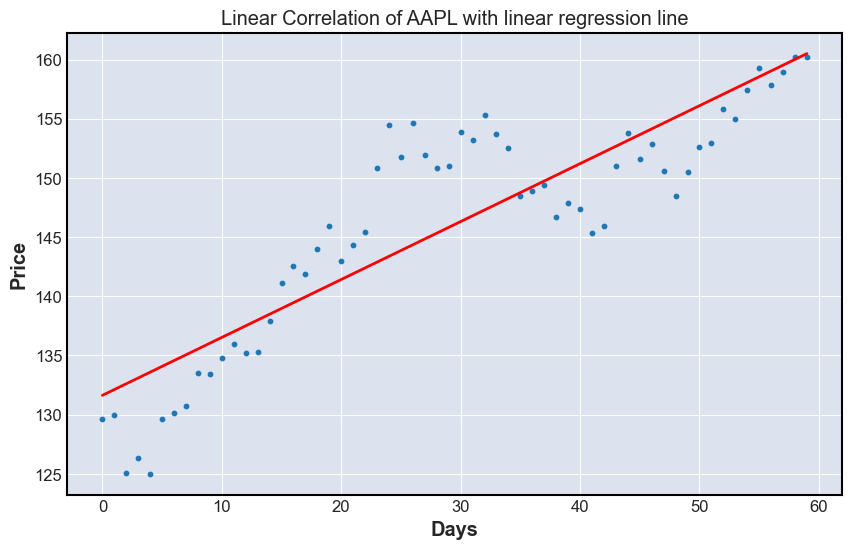

In [166]:
plot_correlation(df_for_plot['AAPL'])

In [131]:
def find_best_linear_stock(directory, days=60):
    df_stats = pd.DataFrame(columns=['ticker', 'R2', 'slope'])
    for i, file in enumerate(os.listdir(directory)):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file), index_col=0, parse_dates=True)
            df = df.iloc[:days,:]
            df = df[['4. close']].iloc[::-1]

            print(f'Processing {file}...')
            X = df['4. close']
            y = range(df.shape[0])

            model = LinearRegression()
            model.fit(np.array(y).reshape(-1,1), X)
            
            df_stats = pd.concat([df_stats, pd.DataFrame({'ticker': file.split('-')[0], 'R2': model.score(np.array(y).reshape(-1,1), X), 'slope': model.coef_[0]}, index=[0])], ignore_index=True)
            
        print(f'{round(i/(len(os.listdir(directory))-1)*100,2)}% completed')
    
    return df_stats

In [ ]:
linear_df = find_best_linear_stock(r'..\P1-Indicators-Chart-Analysis\Data\DailyAll-NASDAQ-100days', days=60)

In [134]:
linear_df.sort_values(by='R2', ascending=False).head(10)

,ticker,R2,slope
2714,SITO,1.000000,0.000000
282,ATRS,1.000000,0.000000
2991,TPCO,1.000000,0.000000
1247,FWP,1.000000,0.000000
2292,PDLI,1.000000,0.000000
2008,MUDS,0.981357,0.001624
497,CATS,0.973285,0.575000
1032,EVLO,0.967811,-0.022502
3300,XOG,0.965196,0.505334
2290,PDFS,0.958721,0.223519
